In [1]:
# works with pyjnius 1.3.0 (not with 1.2.1)

import pathlib
import jnius_config
import sys
import time
import os
import pathlib
import csv
import matplotlib.pyplot as plt
import subprocess
import shlex

In [2]:
bf_jar_path=pathlib.Path('./jars/loci_tools.jar')
jnius_config.add_classpath(str(bf_jar_path))

In [3]:
def timer(func):
    def wrapped_func(*args, **kwargs):
        start_time = time.perf_counter()
        func(*args, **kwargs)
        cycle_time = time.perf_counter() - start_time
        cycle_times.append(cycle_time)
        cumulative_times.append(time.perf_counter() - program_start_time)
    return wrapped_func

@timer
def convert_image():
    reader = ImageReader()
    writer = OMETiffWriter()
    
    # to turn off autostitching
    options = DynamicMetadataOptions()
    options.setBoolean(JString('zeissczi.autostitch'), JBool('FALSE'))
    reader.setMetadataOptions(options)

    id_ = pathlib.Path('data/tiled_01.czi')
    out_id = id_.with_suffix('.ome.tif')

    # print(f'Converting {id_.absolute()} to {out_id.name}')

    factory = ServiceFactory()
    service = jnius.cast(OMEXMLService, factory.getInstance(OMEXMLService))
    omexmlMeta = service.createOMEXMLMetadata()
    reader.setMetadataStore(omexmlMeta)
    reader.setId(JString(str(id_)))

    writer.setMetadataRetrieve(omexmlMeta)
    writer.setId(JString(str(out_id)))

    seriesCount = reader.getSeriesCount()

    for s in range(seriesCount): # only do first for testing
        writer.setSeries(s)
        reader.setSeries(s)
        planeCount = reader.getImageCount()
        for p in range(planeCount):
            plane = reader.openBytes(p)
            writer.saveBytes(p, plane)
            # print('.', end='')
        # print()

    writer.close()
    reader.close()

In [4]:
number_of_cycles = 10

cycle_times = []
cumulative_times = []

program_start_time = time.perf_counter()

import jnius
print('python version', sys.version)
print('jnius version', jnius.__version__)
print('java version',jnius.autoclass('java.lang.System').getProperty('java.version'))

DynamicMetadataOptions = jnius.autoclass('loci.formats.in.DynamicMetadataOptions')
JBool = jnius.autoclass('java.lang.Boolean')
JString = jnius.autoclass('java.lang.String')
ImageReader = jnius.autoclass('loci.formats.ImageReader')
IMetaData = jnius.autoclass('loci.formats.meta.IMetadata')
OMETiffWriter = jnius.autoclass('loci.formats.out.OMETiffWriter')
OMEXMLService = jnius.autoclass('loci.formats.services.OMEXMLService')
ServiceFactory = jnius.autoclass('loci.common.services.ServiceFactory')

python version 3.8.3 (default, May 27 2020, 20:54:22) 
[Clang 11.0.3 (clang-1103.0.32.59)]
jnius version 1.3.0
java version 11.0.7


In [5]:
for i in range(number_of_cycles):
    if pathlib.Path('data/tiled_01.ome.tif').exists():
        os.remove('data/tiled_01.ome.tif')
    print('.', end='')
    convert_image()
print()

..........


In [6]:
# run shell command
cmd = f'./timed_bfconvert.sh {"data/tiled_01.czi"} {"data/tiled_01_cli.ome.tif"} {number_of_cycles}'
sp = subprocess.Popen(shlex.split(cmd), stdout=subprocess.PIPE)
while sp.poll() is None:
    if sp.stdout.readline():
        print('.', end='')
print()

bfCycleTimes = []
bfCumulativeTimes = []
with open("./bfconvert_times.csv") as csvfile:
    reader = csv.reader(csvfile) # change contents to floats
    for row in reader: # each row is a list
        bfCycleTimes.append(float(row[0]))
        bfCumulativeTimes.append(float(row[1]))

...........


In [9]:
# run shell command with many subprocess calls
bfCycleTimes_sp_calls = []
bfCumulativeTimes_sp_calls = []

cmd = f'./timed_bfconvert.sh {"data/tiled_01.czi"} {"data/tiled_01_cli_02.ome.tif"} 1'
loop_start = time.perf_counter()
for i in range(number_of_cycles):
    cycle_start = time.perf_counter()
    sp = subprocess.Popen(shlex.split(cmd), stdout=subprocess.PIPE)
    while sp.poll() is None:
        if sp.stdout.readline():
            print('.', end='')
    cycle_end = time.perf_counter()
    bfCycleTimes_sp_calls.append(cycle_end - cycle_start)
    bfCumulativeTimes_sp_calls.append(cycle_end - loop_start)
print()


..........


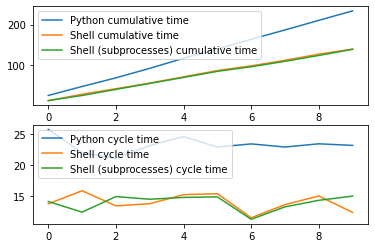

In [8]:
# plot performance
fig, axs = plt.subplots(2)
axs[0].plot(cumulative_times, label='Python cumulative time')
axs[0].plot(bfCumulativeTimes, label='Shell cumulative time')
axs[0].plot(bfCumulativeTimes_sp_calls, label='Shell (subprocesses) cumulative time')
axs[1].plot(cycle_times, label='Python cycle time')
axs[1].plot(bfCycleTimes, label='Shell cycle time')
axs[1].plot(bfCycleTimes_sp_calls, label='Shell (subprocesses) cycle time')

for ax in axs:
    ax.legend()